# Experiments with a Perceptron Model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import math

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) #Set default plot sizes
plt.rcParams['image.interpolation'] = 'nearest' #Use nearest neighbor for rendering

In [4]:
# Allowing notebooks to reload external python modules
# Details: http://stackoverflow.com/questions/1907993/aut
%load_ext autoreload
%autoreload 2

## Data Set
For this simple example, I will use a handcrafted dataset

In [13]:
#here is an artificial dataset
x1 = np.array(np.arange(0.1,0.7,0.1))
print("x1:", np.exp(x1*0.3))
x2 = np.array(np.arange(0.6,1.1,0.1))
print("x2:", np.exp(x2*0.6))

#e^(W11*x1 + W12*x2 + B1)
print("Exponentiated values:", np.exp(0.3*x1 + 0.6*x2 + 0.5))

#From the output, lets use 3 as threshold; Value>3 = class 1, value<3 = class 0
Y = np.array([0,0,0,1,1,1])
X = np.array([x1,x2])

x1: [ 1.03045453  1.06183655  1.09417428  1.12749685  1.16183424  1.19721736]
x2: [ 1.43332941  1.52196156  1.6160744   1.71600686  1.8221188   1.93479233]
Exponentiated values: [ 2.43512965  2.66445624  2.9153795   3.18993328  3.49034296  3.81904351]


Let us define the numerically stable version of sigmoid function
Note that we can write 
$\frac{1}{1+e^-z}$ as $\frac{e^z}{1+e^z}$

In [14]:
import numpy as np
def sigmoid(x):
    x = np.clip(x, -500,500)
    if x.any()>=0:
        return 1/(1+ np.exp(-x))
    else:
        return np.exp(x)/(1 + np.exp(x))

### Initialize Parameters

In [15]:
def init_parameters(dim1, dim2=1,std=1e-1, random = True):
    if(random):
        return(np.random.random([dim1,dim2])*std)
    else:
        return(np.zeros([dim1,dim2]))

In [16]:
#Single layer network: Forward Prop
def fwd_prop(W1,B1,X,Y):
    n_0 = np.shape(X)[0]
    m   = np.shape(X)[1]
    n_1 = np.shape(W1)[0]     
    #print("n_0:",n_0)
    #print("m:",m)
    #print("n_1",n_1)
    
    #Dimensions
    # X = (n_0,m)
    # W1 = (n_1,n_0)
    # B1 = (n_1,1) -> Broadcast -> (n_1,m)
    # Z1 = (n_1,m)
    # A1 = (n_1,m)
    Z1 = np.dot(W1,X) + B1#
    A1 = sigmoid(Z1)
    #print("A1 shape", np.shape(A1))
    return(A1)

In [17]:
#Single layer network: Backprop

def back_prop(A1,W1,B1,X,Y):
    n_0 = np.shape(X)[0]
    m   = np.shape(X)[1]
    n_1 = np.shape(W1)[0]
    
    
    cost = (-1/m)*np.sum(Y*np.log(A1) + (1-Y)*np.log(1-A1))
    #shape(dA1) = shape(A1) = (n_1,m)
    dA1 = Y/A1 + (1-Y)/(1-A1)
    
    #shape(dZ1) = shape(Z1) = (n_1,m)
    dZ1 = A1 - Y
    
    #shape(dW1) = shape(W1) = (n_1,n_0)
    dW1 = (1/m) * np.dot(dZ1, X.T) # dZ1 = (n_1,m), X ->(n_0,m)
    
    #shape(dB1) = shape(B1) = (n_1,1)
    dB1 = (1/m) * np.sum(dZ1, axis = 1, keepdims = True)
    
    grads ={"dW1": dW1, "dB1":dB1}
    
    return(grads,cost)

In [18]:
def run_grad_desc(num_iterations, learning_rate,X,Y,n_1):
    n_0, m = np.shape(X)
    
    W1 = init_parameters(n_1, n_0, random= False)
    B1 = init_parameters(n_1,1, random = False)
    
    loss_array = np.ones([num_iterations])*np.nan
    for i in np.arange(num_iterations):
        A1 = fwd_prop(W1,B1,X,Y)
        grads,cost = back_prop(A1,W1,B1,X,Y)
        
        W1 = W1 - learning_rate*grads["dW1"]
        B1 = B1 - learning_rate*grads["dB1"]
        
        loss_array[i] = cost
        
        parameter = {"W1":W1,"B1":B1}
    
    return(parameter,loss_array)

In [27]:
params, loss_array = run_grad_desc(100000,0.001,X,Y,n_1= 1 )
#print(loss_array)
print(params)

{'B1': array([[-3.25316109]]), 'W1': array([[ 3.96198982,  2.33540927]])}


In [28]:
X[0]*params["W1"][0][0]* X[1]*params["W1"][0][1] + params["B1"][0]

array([-2.69798902, -1.9577596 , -1.03247283,  0.0778713 ,  1.37327279,
        2.85373163])

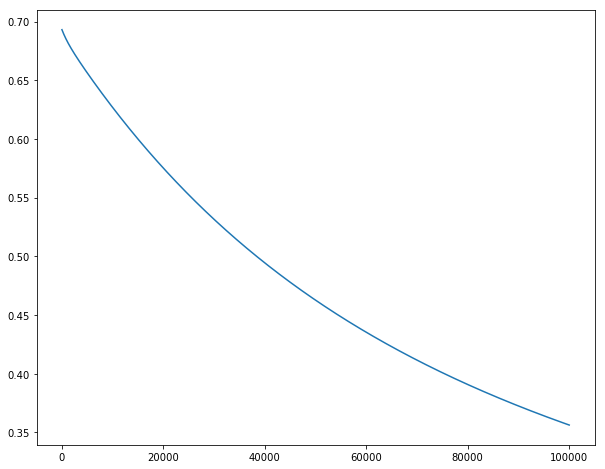

In [29]:
plt.plot(loss_array)

In [30]:
X = np.array([[0.25,0.75],[0.1,0.9],[0.3,0.8],[0.8,0.25],[0.9,0.2],[0.7,0.1]])
X = np.array([[0.11,0.12],[0.05,0.1],[0.15,0.11],[0.8,0.9],[0.9,0.8],[0.85,0.95]])
X = X.T
Y = np.array([1,1,1,0,0,0])
params, loss_array = run_grad_desc(100,0.01,X,Y,n_1= 1 )
#print(loss_array)
X[0]*params["W1"][0][0]* X[1]*params["W1"][0][1] + params["B1"][0]


array([ 0.02023499,  0.01998696,  0.0203348 ,  0.04161376,  0.04161376,
        0.0442604 ])